
<div style="text-align: center;">
  <img width="420" height="420" src="https://www.naterscreations.com/imputegap/logo_imputegab.png" />
</div>

<h1>ImputeGAP: Explore Notebook</h1>

ImputeGAP is an end-to-end imputation library that implements the full imputation pipeline
from data collection to explaining the imputation results and their impact. It encompasses
two interleaving units: repair and explore. The two units can be accessed via a standardized
pipeline defined by configuration files or independent instantiation. This notebook demonstrate the Benchmark, the Downstream evaluation and the Explainer, part of the explore unit. Please, install the library and the jupyter requirements:

In [ ]:
%pip install imputegap==1.0.8

In [ ]:
%pip install -U ipywidgets
%matplotlib inline

<h1>Benchmark</h1>

ImputeGAP can serve as a common test-bed for comparing the effectiveness and efficiency of time series imputation algorithms. Users have full control over the benchmark by customizing various parameters, including the list of the algorithms to compare, the optimizer, the datasets to evaluate, the missingness patterns, the range of missing values, and the performance metrics.

The benchmarking module can be utilized as follows:


(SYS) The time series have been loaded from /mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/dataset/eeg-alcohol.txt

pattern : mcar, algorithm SoftImpute, started at 2025-04-04 13:00:44.
done!


pattern : mcar, algorithm KNNImpute, started at 2025-04-04 13:00:46.
done!




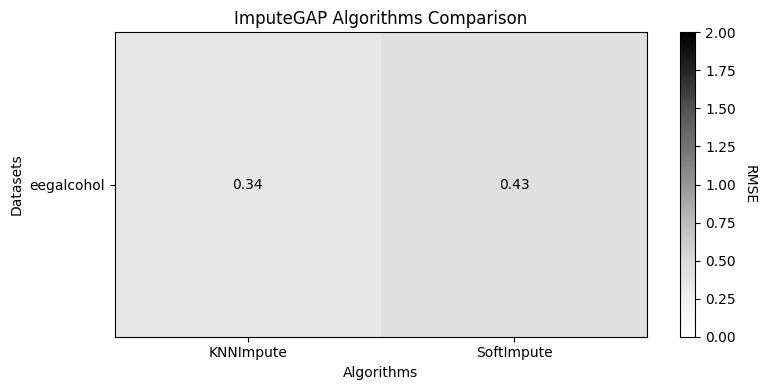

the results of the analysis has been saved in :  ./imputegap_assets/benchmark 


> logs: benchmark - Execution Time: 6.9101 seconds


Dataset: eegalcohol, pattern: mcar, metric: RMSE, parms=default_params

 Rate       KNNImpute           SoftImpute     

 0.05      0.2410259540        0.4359915238    
  0.1      0.2889085181        0.3665001858    
  0.2      0.3252384253        0.3983300622    
  0.4      0.3382458476        0.4355910162    
  0.6      0.3656435952        0.4500113662    
  0.8      0.4985193265        0.4655442240    



Dataset: eegalcohol, pattern: mcar, metric: runtime_linear_scale, parms=default_params

 Rate       KNNImpute           SoftImpute     

 0.05      0.0506560802        0.5533447266    
  0.1      0.0385241508        0.3406643867    
  0.2      0.0217945576        0.4643659592    
  0.4      0.0786936283        0.1619021893    
  0.6      0.1070687771        0.2423040867    
  0.8      0.1176316738        0.1671948433    



results saved in the follo

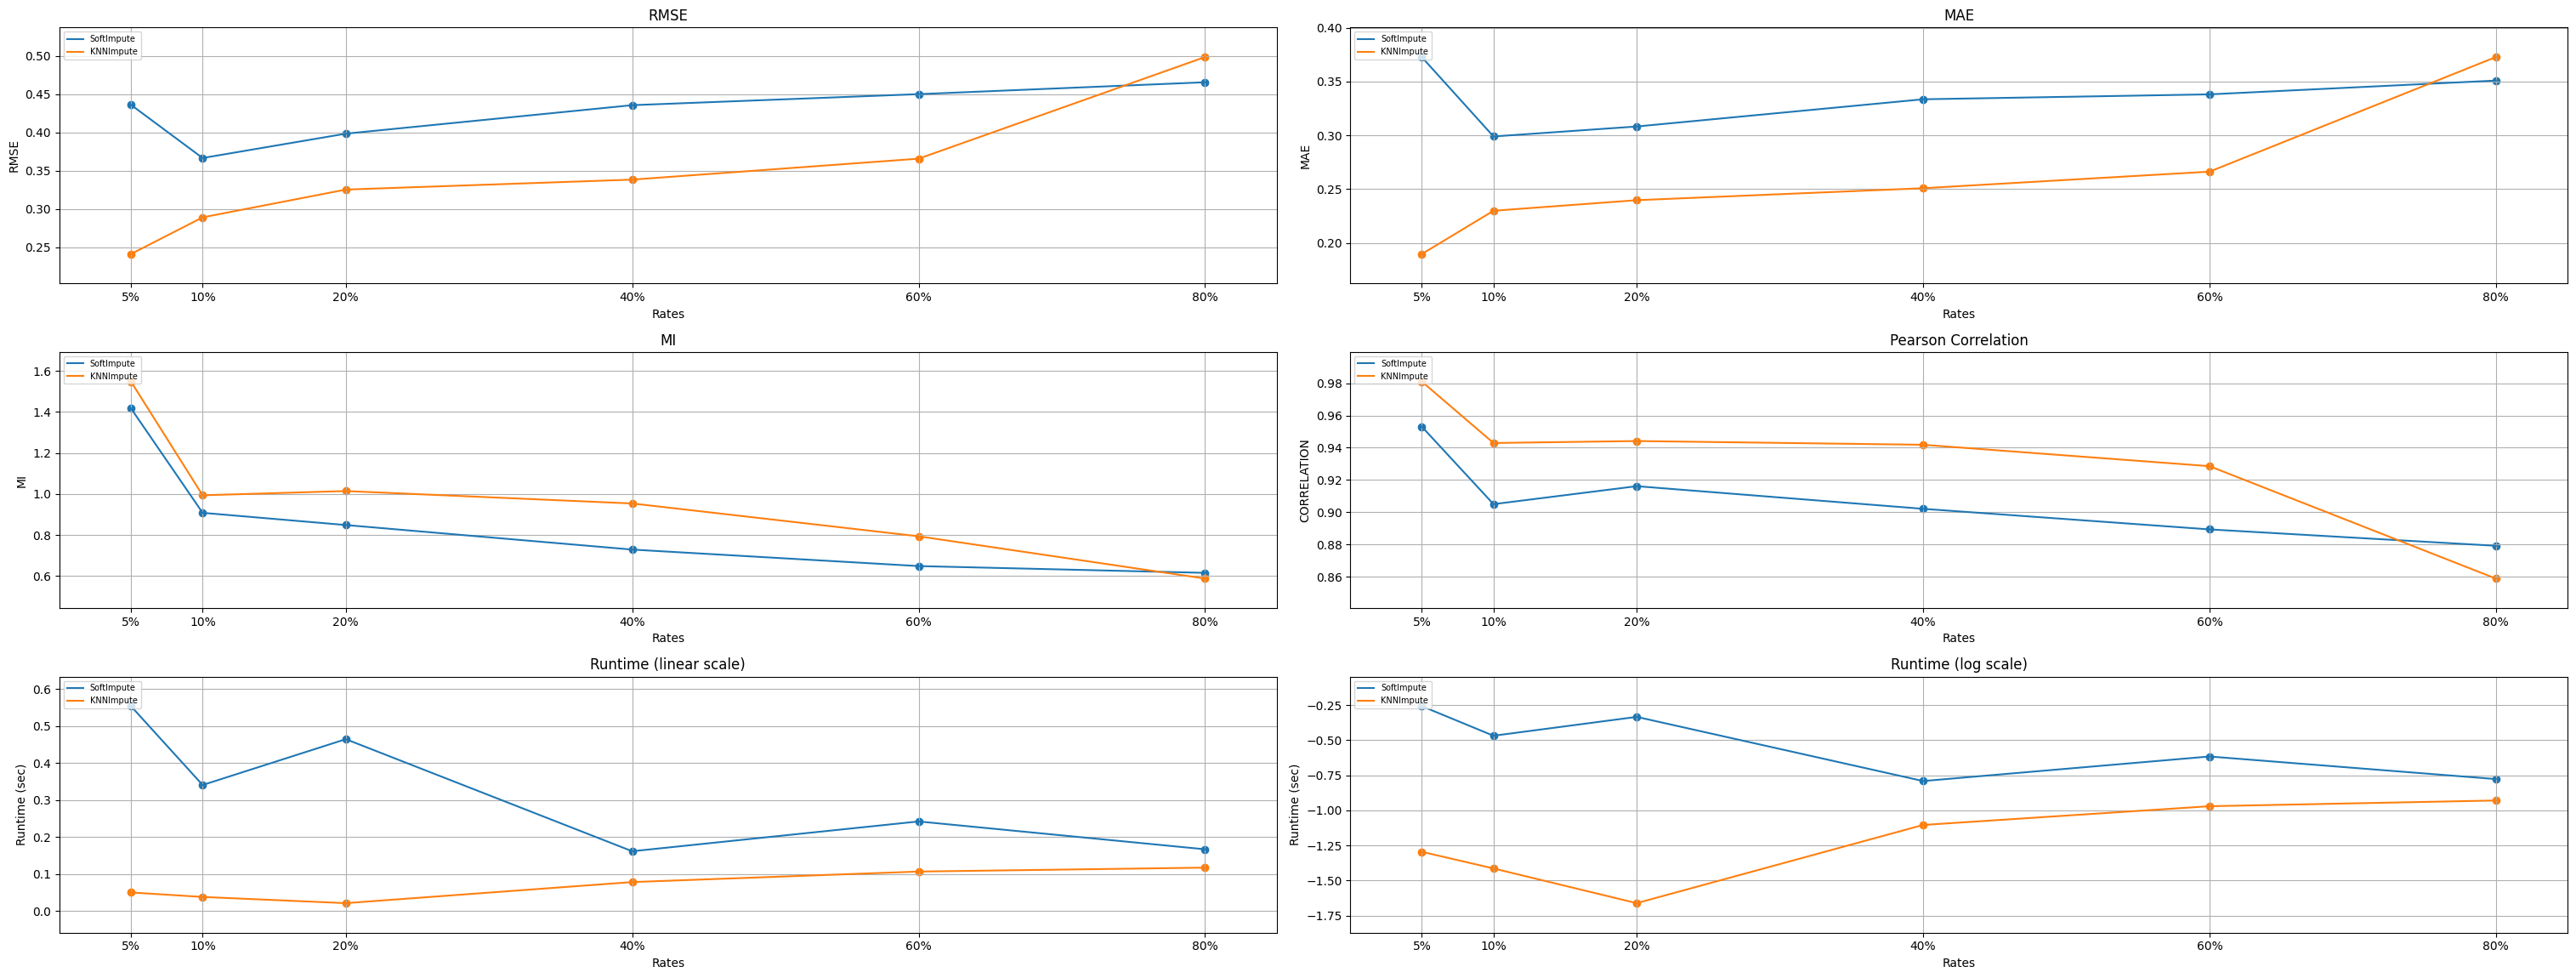


plots saved in the following directory :  ./imputegap_assets/benchmark/eegalcohol





In [8]:
%matplotlib inline
from imputegap.recovery.benchmark import Benchmark

my_algorithms = ["SoftImpute", "KNNImpute"]

my_opt = ["default_params"]

my_datasets = ["eeg-alcohol"]

my_patterns = ["mcar"]

range = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]

my_metrics = ["*"]

# launch the evaluation
bench = Benchmark()
bench.eval(algorithms=my_algorithms, datasets=my_datasets, patterns=my_patterns, x_axis=range, metrics=my_metrics, optimizers=my_opt)

You can enable the optimizer using the following command:

In [9]:
opt = {"optimizer": "ray_tune", "options": {"n_calls": 1, "max_concurrent_trials": 1}}
my_opt = [opt]

<br>

<h1>Downstream</h1>

ImputeGAP includes a dedicated module for systematically evaluating the impact of data imputation on downstream tasks. Currently, forecasting is the primary supported task, with plans to expand to additional tasks in the future.


(SYS) The time series have been loaded from /mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/dataset/forecast-economy.txt

> logs: normalization (z_score) of the data - runtime: 0.0005 seconds

(CONT) missigness pattern: ALIGNED
	rate series impacted: 20.0%
	missing rate per series: 80.0%
	starting position: 93
	index impacted : 93 -> 837

(IMPUTATION) CDRec: (16,931) for rank 3, epsilon 1e-06, and iterations 100.
> logs: imputation cdrec - Execution Time: 5.7019 seconds.

(DOWNSTREAM) Default parameters of the downstream model loaded.

(DOWNSTREAM) Analysis launched !
task: forecast
model: hw-add
params: {'sp': 7, 'trend': 'add', 'seasonal': 'additive'}
imputation algorithm: cdrec
comparator: ZeroImpute


plots saved in  ./imputegap_assets/downstream/25_04_04_13_01_11_forecast_hw-add_downstream.jpg


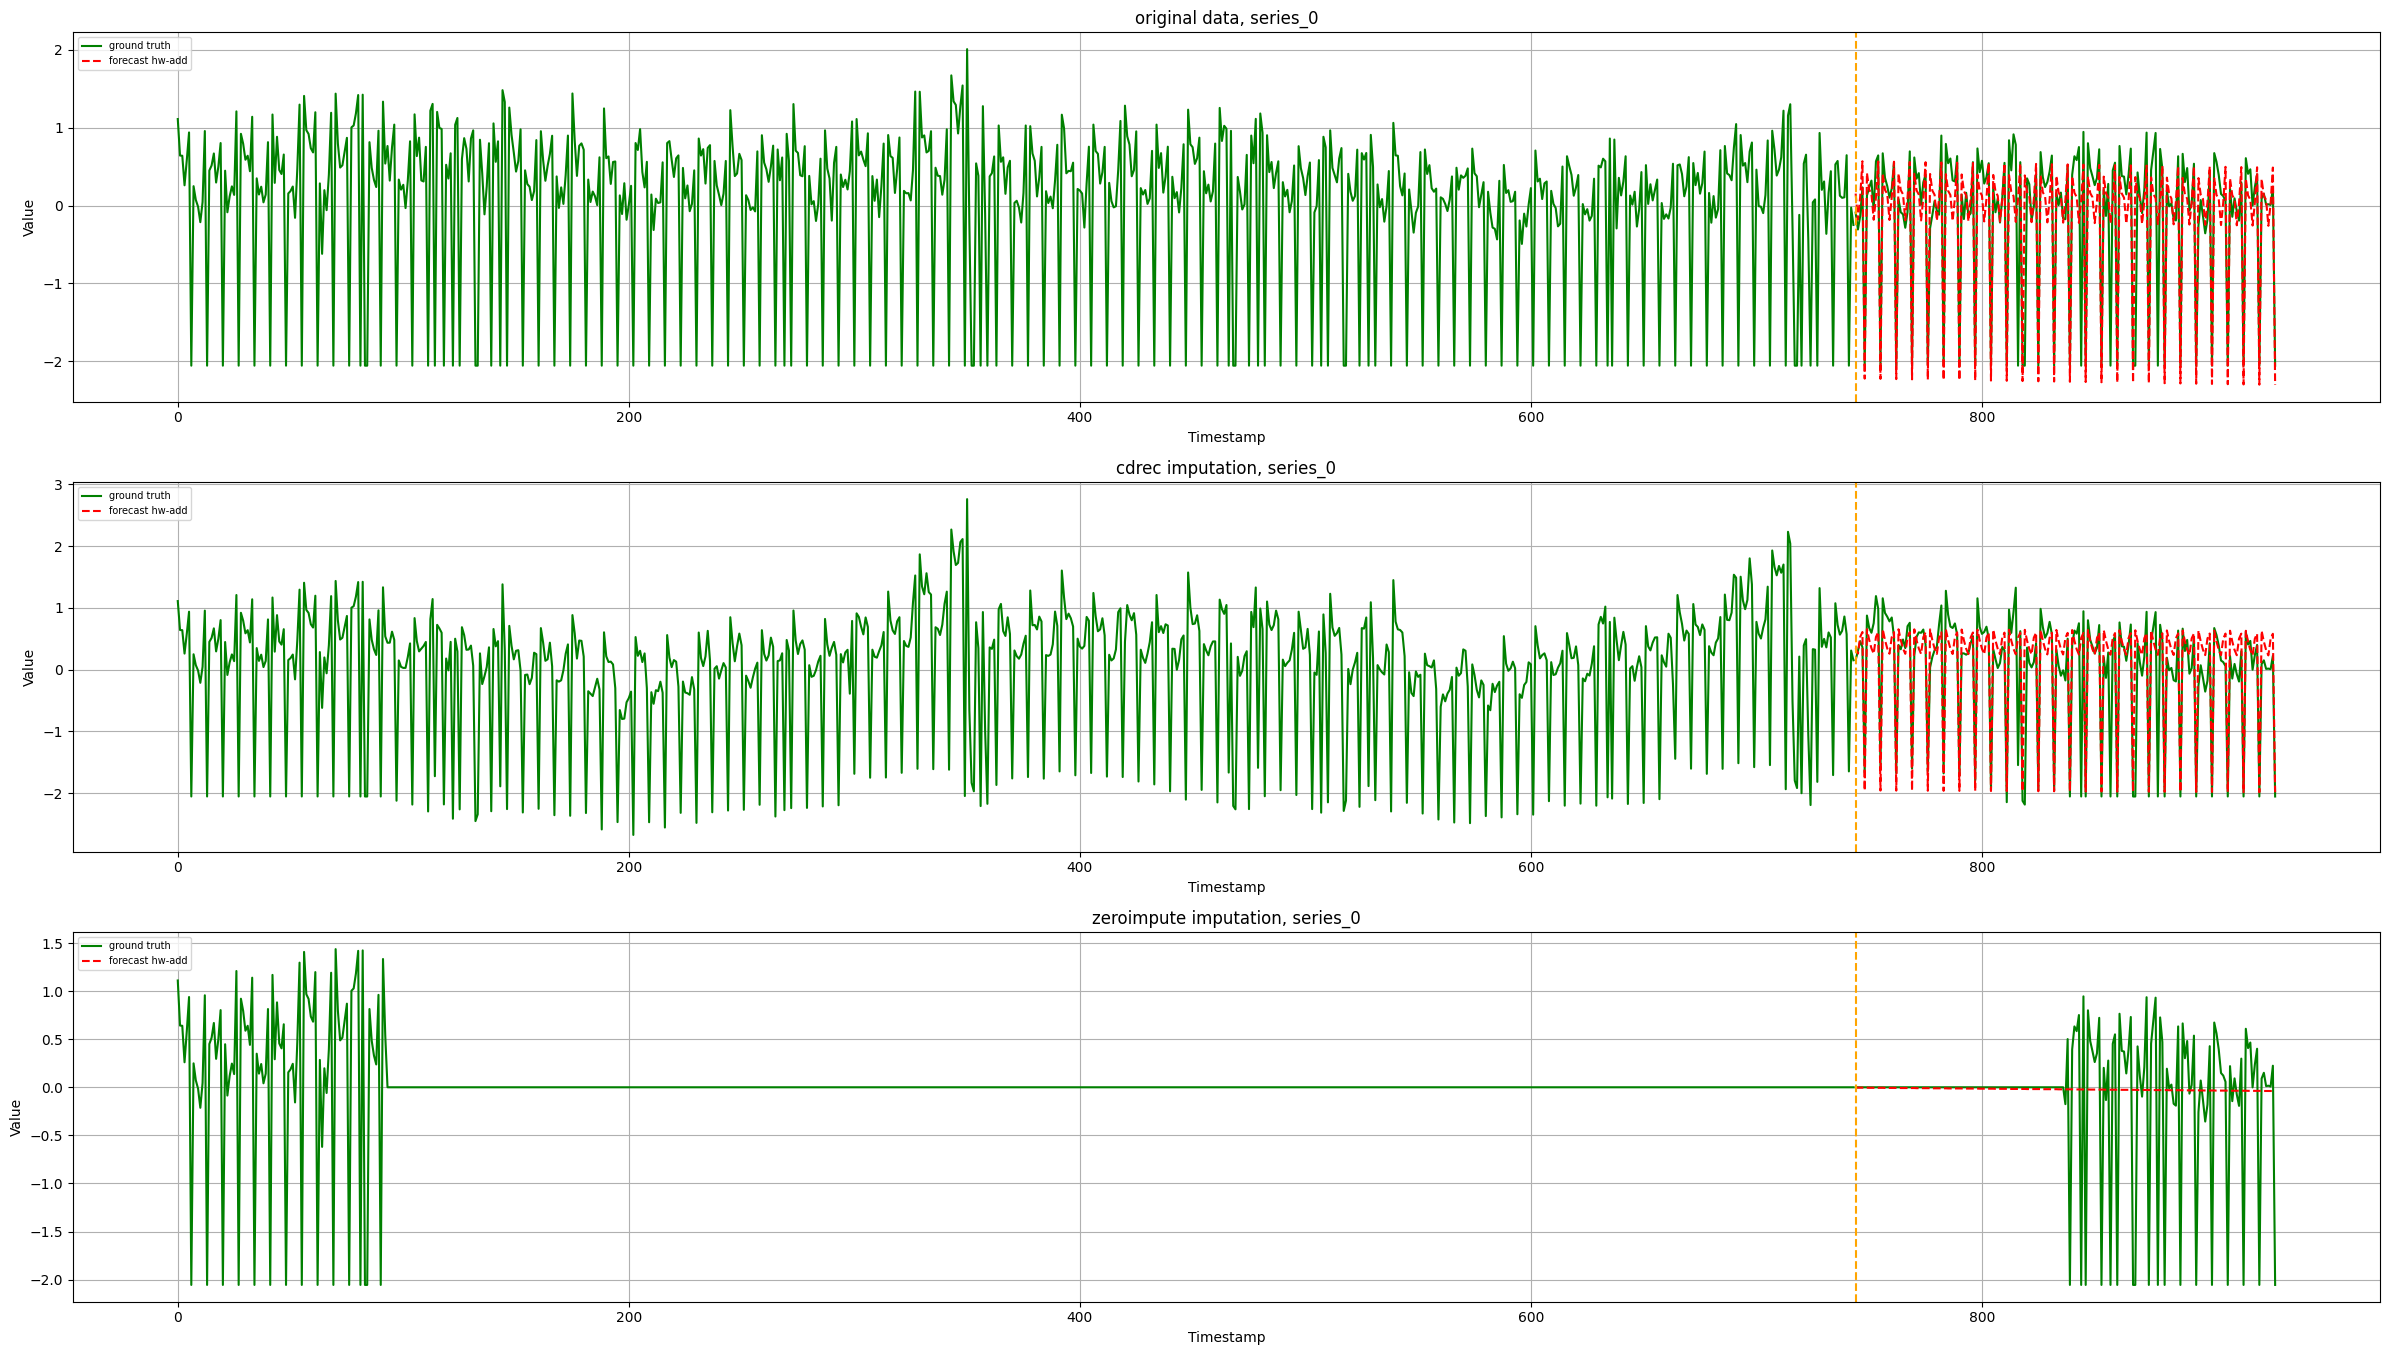


Results of the analysis (cdrec) :
MSE_original         = 0.5664449450187778
MSE_CDREC            = 0.5849456079752088
MSE_ZEROIMPUTE       = 0.6242535371188614
sMAPE_original       = 89.44732801706094
sMAPE_CDREC          = 94.18574068369821
sMAPE_ZEROIMPUTE     = 120.24881115475135


In [10]:
%matplotlib inline
from imputegap.recovery.imputation import Imputation
from imputegap.recovery.manager import TimeSeries
from imputegap.tools import utils

# initialize the time series object
ts = TimeSeries()

# load and normalize the timeseries
ts.load_series(utils.search_path("forecast-economy"))
ts.normalize()

# contaminate the time series
ts_m = ts.Contamination.aligned(ts.data, rate_series=0.8)

# define and impute the contaminated series
imputer = Imputation.MatrixCompletion.CDRec(ts_m)
imputer.impute()

# compute and print the downstream results
downstream_config = {"task": "forecast", "model": "hw-add", "comparator": "ZeroImpute"}
imputer.score(ts.data, imputer.recov_data, downstream=downstream_config)
ts.print_results(imputer.downstream_metrics, algorithm=imputer.algorithm)

<br>

All downstream models develboped in ImputeGAP are available in the ``ts.forecasting_models`` module, which can be listed as follows:

In [11]:
ts.forecasting_models

['arima',
 'bats',
 'croston',
 'deepar',
 'ets',
 'exp-smoothing',
 'hw-add',
 'lightgbm',
 'lstm',
 'naive',
 'nbeats',
 'prophet',
 'sf-arima',
 'theta',
 'transformer',
 'unobs',
 'xgboost']

<br>

<h1>Explainer</h1>

The library provides insights into the algorithm’s behavior by identifying the features that impact the imputation results. It trains a regression model to predict imputation results across various methods and uses SHapley Additive exPlanations (SHAP) to reveal how different time series features influence the model’s predictions.

Let’s illustrate the explainer using the CDRec algorithm and MCAR missingness pattern:


(SYS) The time series have been loaded from /mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/dataset/eeg-alcohol.txt

> logs: normalization (z_score) of the data - runtime: 0.0007 seconds

explainer launched
	extractor: pycatch 
	imputation algorithm: CDRec 
	params: None 
	missigness pattern: mcar
	missing rate: 40.0%
	nbr of series training set: 38
	nbr of series testing set: 26


Generation  0 / 64 ( 0 %)________________________________________________________
	Contamination  0 ...
	pycatch22 : features extracted successfully___22 features
	Imputation  0 ...


Generation  1 / 64 ( 1 %)________________________________________________________
	Contamination  1 ...
	pycatch22 : features extracted successfully___22 features
	Imputation  1 ...


Generation  2 / 64 ( 3 %)________________________________________________________
	Contamination  2 ...
	pycatch22 : features extracted successfully___22 features
	Imputation  2 ...


Generation  3 / 64 ( 4 %)_________________

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

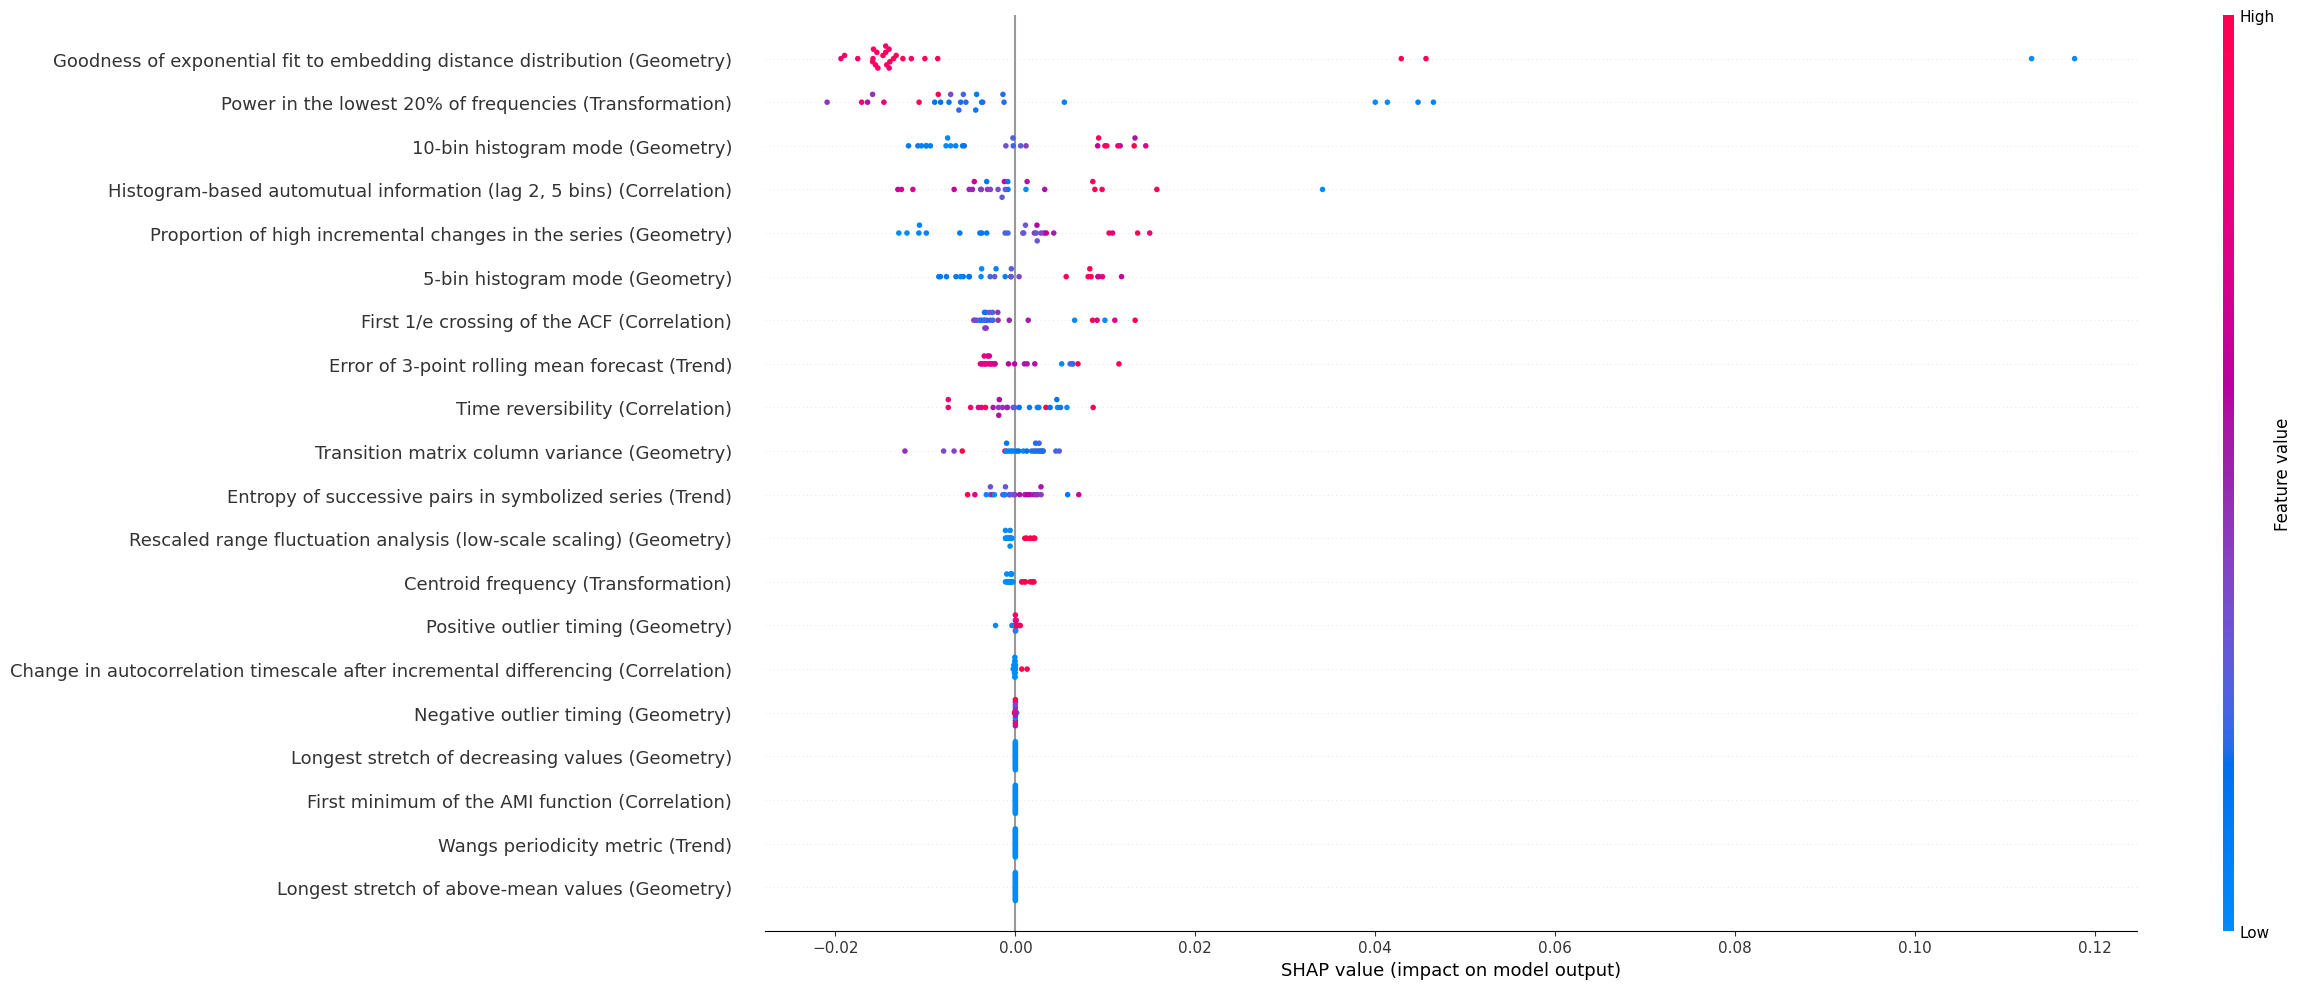

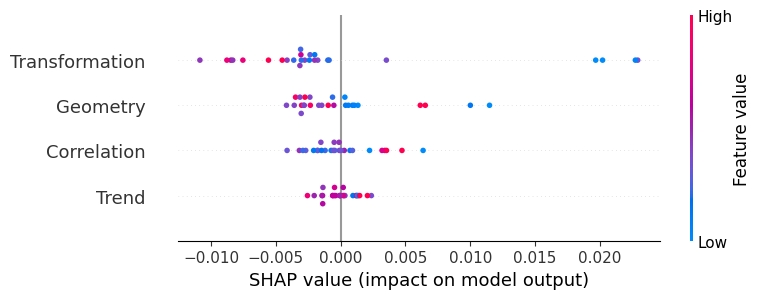



	plot has been saved :  ./imputegap_assets/shap/eeg-alcohol_CDRec_pycatch_shap_all.png


	plot has been saved :  ./imputegap_assets/shap/eeg-alcohol_CDRec_pycatch_shap_cat.png


SHAP Explainer succeeded without fail, please find the results in : ./assets/shap/*


> logs: shap explainer - Execution Time: 78.3587 seconds



RMSE RESULTS (Y_TRAIN & Y_TEST): [0.45712812941363784, 0.5438438381672798, 0.26549016484114774, 0.6105707617030077, 0.30099782224277555, 0.2164511752833264, 0.4258210464001942, 0.49646942242787734, 0.2908816022128108, 0.4283227993704841, 0.3207427796465851, 0.4398059681001497, 0.4764330479065498, 0.4266036476868759, 0.32841220128853227, 0.5915170961060447, 0.4201599511374143, 0.5387023888018027, 0.7277953548636557, 0.36474897528179967, 0.38156484280457104, 0.40154479113393404, 0.21356345156822473, 0.22670635531640648, 0.3895808876858397, 0.41574772833042145, 0.3527871845087997, 0.4212383324210313, 0.34003105850764775, 0.4145000823792042, 0.450283153846639, 0.6233453

In [13]:
%matplotlib inline
from imputegap.recovery.manager import TimeSeries
from imputegap.recovery.explainer import Explainer
from imputegap.tools import utils

# initialize the time series object
ts = TimeSeries()
exp = Explainer()

# load and normalize the timeseries
ts.load_series(utils.search_path("eeg-alcohol"))
ts.normalize(normalizer="z_score")

# configure the explanation
exp.shap_explainer(input_data=ts.data, extractor="pycatch", pattern="mcar", file_name=ts.name, algorithm="CDRec", display=True)

# print the impact of each feature
exp.print(exp.shap_values, exp.shap_details)

<br>

All feature extractors developed in ImputeGAP are available in the ``ts.extractors`` module. They can be listed as follows:

In [15]:
ts.extractors

['pycatch', 'tsfel', 'tsfresh']